In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
from tqdm import tqdm
from PIL import Image
import os

In [95]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dirs, transform=None):
        self.image_dirs = image_dirs
        self.transform = transform
        self.image_paths = []
        for image_dir in image_dirs:
            self.image_paths.extend([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
                            if os.path.isfile(os.path.join(image_dir, fname))])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        print(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0

## Seed, Real bdd10k train and generated dataset represented with PCA in 3D, probably lack of night pictures

In [82]:
# Конфигурация
DEVICE = 'cuda:3' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
IMG_SIZE = 224

# 1. Загрузка предобученной модели
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Убираем последний слой
model = model.to(DEVICE).eval()

# 2. Преобразования изображений
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. Функция извлечения эмбеддингов
def extract_embeddings(dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            features = model(images.to(DEVICE))
            embeddings.append(features.squeeze().cpu().numpy())
    return np.vstack(embeddings)

# 4. Загрузка данных (замените пути на свои)
gen_paths = ['/home/alexblokh/diffusion/data/generated_dataset/yolo_format/images/train']
real_paths = ['/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train']
seed_paths = ['/home/alexblokh/diffusion/data/seed_images/bdd_images']

real_dataset = CustomImageDataset(real_paths, transform=transform)
gen_dataset = CustomImageDataset(gen_paths, transform=transform)
seed_dataset = CustomImageDataset(seed_paths, transform=transform)

real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=BATCH_SIZE)
gen_loader = torch.utils.data.DataLoader(gen_dataset, batch_size=BATCH_SIZE)
seed_loader = torch.utils.data.DataLoader(seed_dataset, batch_size=BATCH_SIZE)

# 5. Извлечение признаков
real_emb_init = extract_embeddings(real_loader)
gen_emb_init = extract_embeddings(gen_loader)
seed_emb_init = extract_embeddings(seed_loader)

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


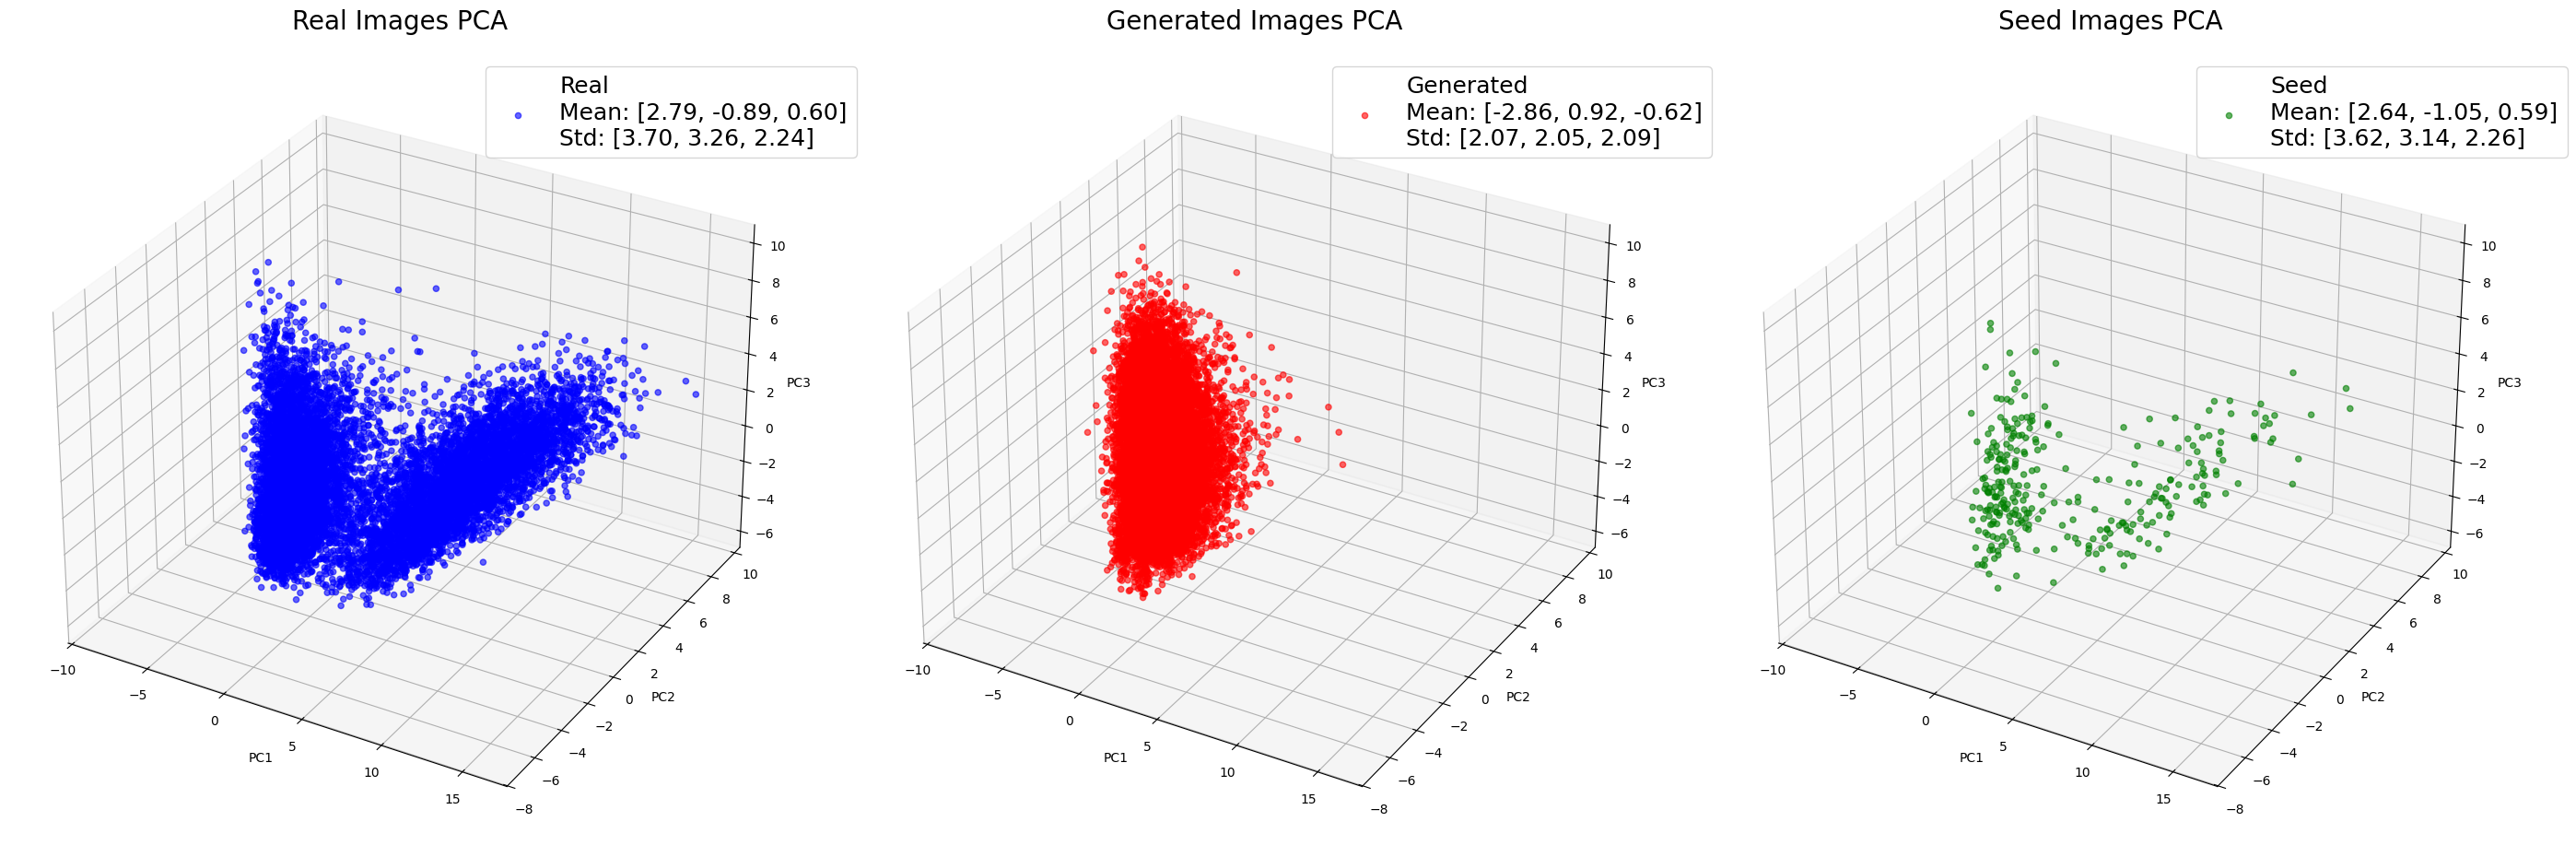


Подробные статистики:
Dataset | PC1 Mean | PC1 Std | PC2 Mean | PC2 Std | PC3 Mean | PC3 Std
------------------------------------------------------------------------------------------
Real | 2.79 | 3.70 | -0.89 | 3.26 | 0.60 | 2.24
Generated | -2.86 | 2.07 | 0.92 | 2.05 | -0.62 | 2.09
Seed | 2.64 | 3.62 | -1.05 | 3.14 | 0.59 | 2.26


In [89]:
pca = PCA(n_components=3)
combined_emb = np.vstack([real_emb_init, gen_emb_init, seed_emb_init])
pca.fit(combined_emb)

# Преобразуем все наборы
real_pca = pca.transform(real_emb_init)
gen_pca = pca.transform(gen_emb_init)
seed_pca = pca.transform(seed_emb_init)

# 7. Создание фигуры с 3D субплотами
fig = plt.figure(figsize=(28, 9))

# Общие пределы для всех графиков
all_pca = np.vstack([real_pca, gen_pca, seed_pca])
x_lim = (all_pca[:,0].min()-1, all_pca[:,0].max()+1)
y_lim = (all_pca[:,1].min()-1, all_pca[:,1].max()+1)
z_lim = (all_pca[:,2].min()-1, all_pca[:,2].max()+1)

# Функция для форматирования статистик
def get_stats_text(data, label):
    mean = data.mean(axis=0).round(2)
    std = data.std(axis=0).round(2)
    return (f"{label}\n"
            f"Mean: [{mean[0]:.2f}, {mean[1]:.2f}, {mean[2]:.2f}]\n"
            f"Std: [{std[0]:.2f}, {std[1]:.2f}, {std[2]:.2f}]")

# График для реальных данных (Real)
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(real_pca[:,0], real_pca[:,1], real_pca[:,2],
                 c='blue', alpha=0.6, label=get_stats_text(real_pca, "Real"))
ax1.set_title('Real Images PCA', pad=20, fontsize=20)
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)
ax1.set_zlim(z_lim)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend(handles=[sc1], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

# График для сгенерированных данных (Generated)
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(gen_pca[:,0], gen_pca[:,1], gen_pca[:,2],
                 c='red', alpha=0.6, label=get_stats_text(gen_pca, "Generated"))
ax2.set_title('Generated Images PCA', pad=20, fontsize=20)
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_zlim(z_lim)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend(handles=[sc2], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

# График для seed данных (Seed)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(seed_pca[:,0], seed_pca[:,1], seed_pca[:,2],
                 c='green', alpha=0.6, label=get_stats_text(seed_pca, "Seed"))
ax3.set_title('Seed Images PCA', pad=20, fontsize=20)
ax3.set_xlim(x_lim)
ax3.set_ylim(y_lim)
ax3.set_zlim(z_lim)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.legend(handles=[sc3], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

plt.tight_layout()
plt.show()

# 8. Детальный вывод статистик в консоль
print("\nПодробные статистики:")
print(f"{'Dataset'} | {'PC1 Mean'} | {'PC1 Std'} | {'PC2 Mean'} | {'PC2 Std'} | {'PC3 Mean'} | {'PC3 Std'}")
print("-" * 90)
for name, data in [('Real', real_pca), ('Generated', gen_pca), ('Seed', seed_pca)]:
    mean = data.mean(axis=0).round(2)
    std = data.std(axis=0).round(2)
    print(f"{name} | {mean[0]:.2f} | {std[0]:.2f} | {mean[1]:.2f} | {std[1]:.2f} | {mean[2]:.2f} | {std[2]:.2f}")

## Seed, Real bdd10k train and generated dataset represented with PCA in 3D after some night pictures were generated

In [92]:
# Конфигурация
DEVICE = 'cuda:3' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
IMG_SIZE = 224

# 1. Загрузка предобученной модели
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Убираем последний слой
model = model.to(DEVICE).eval()

# 2. Преобразования изображений
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 3. Функция извлечения эмбеддингов
def extract_embeddings(dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            features = model(images.to(DEVICE))
            embeddings.append(features.squeeze().cpu().numpy())
    return np.vstack(embeddings)

# 4. Загрузка данных (замените пути на свои)
gen_paths = ['/home/alexblokh/diffusion/data/generated_dataset/yolo_format/images/train',
             '/home/alexblokh/diffusion/images_with_trucks']
real_paths = ['/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train']
seed_paths = ['/home/alexblokh/diffusion/data/seed_images/bdd_images']

real_dataset = CustomImageDataset(real_paths, transform=transform)
gen_dataset = CustomImageDataset(gen_paths, transform=transform)
seed_dataset = CustomImageDataset(seed_paths, transform=transform)

real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=BATCH_SIZE)
gen_loader = torch.utils.data.DataLoader(gen_dataset, batch_size=BATCH_SIZE)
seed_loader = torch.utils.data.DataLoader(seed_dataset, batch_size=BATCH_SIZE)

# 5. Извлечение признаков
gen_emb = extract_embeddings(gen_loader)
real_emb = extract_embeddings(real_loader)
seed_emb = extract_embeddings(seed_loader)

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


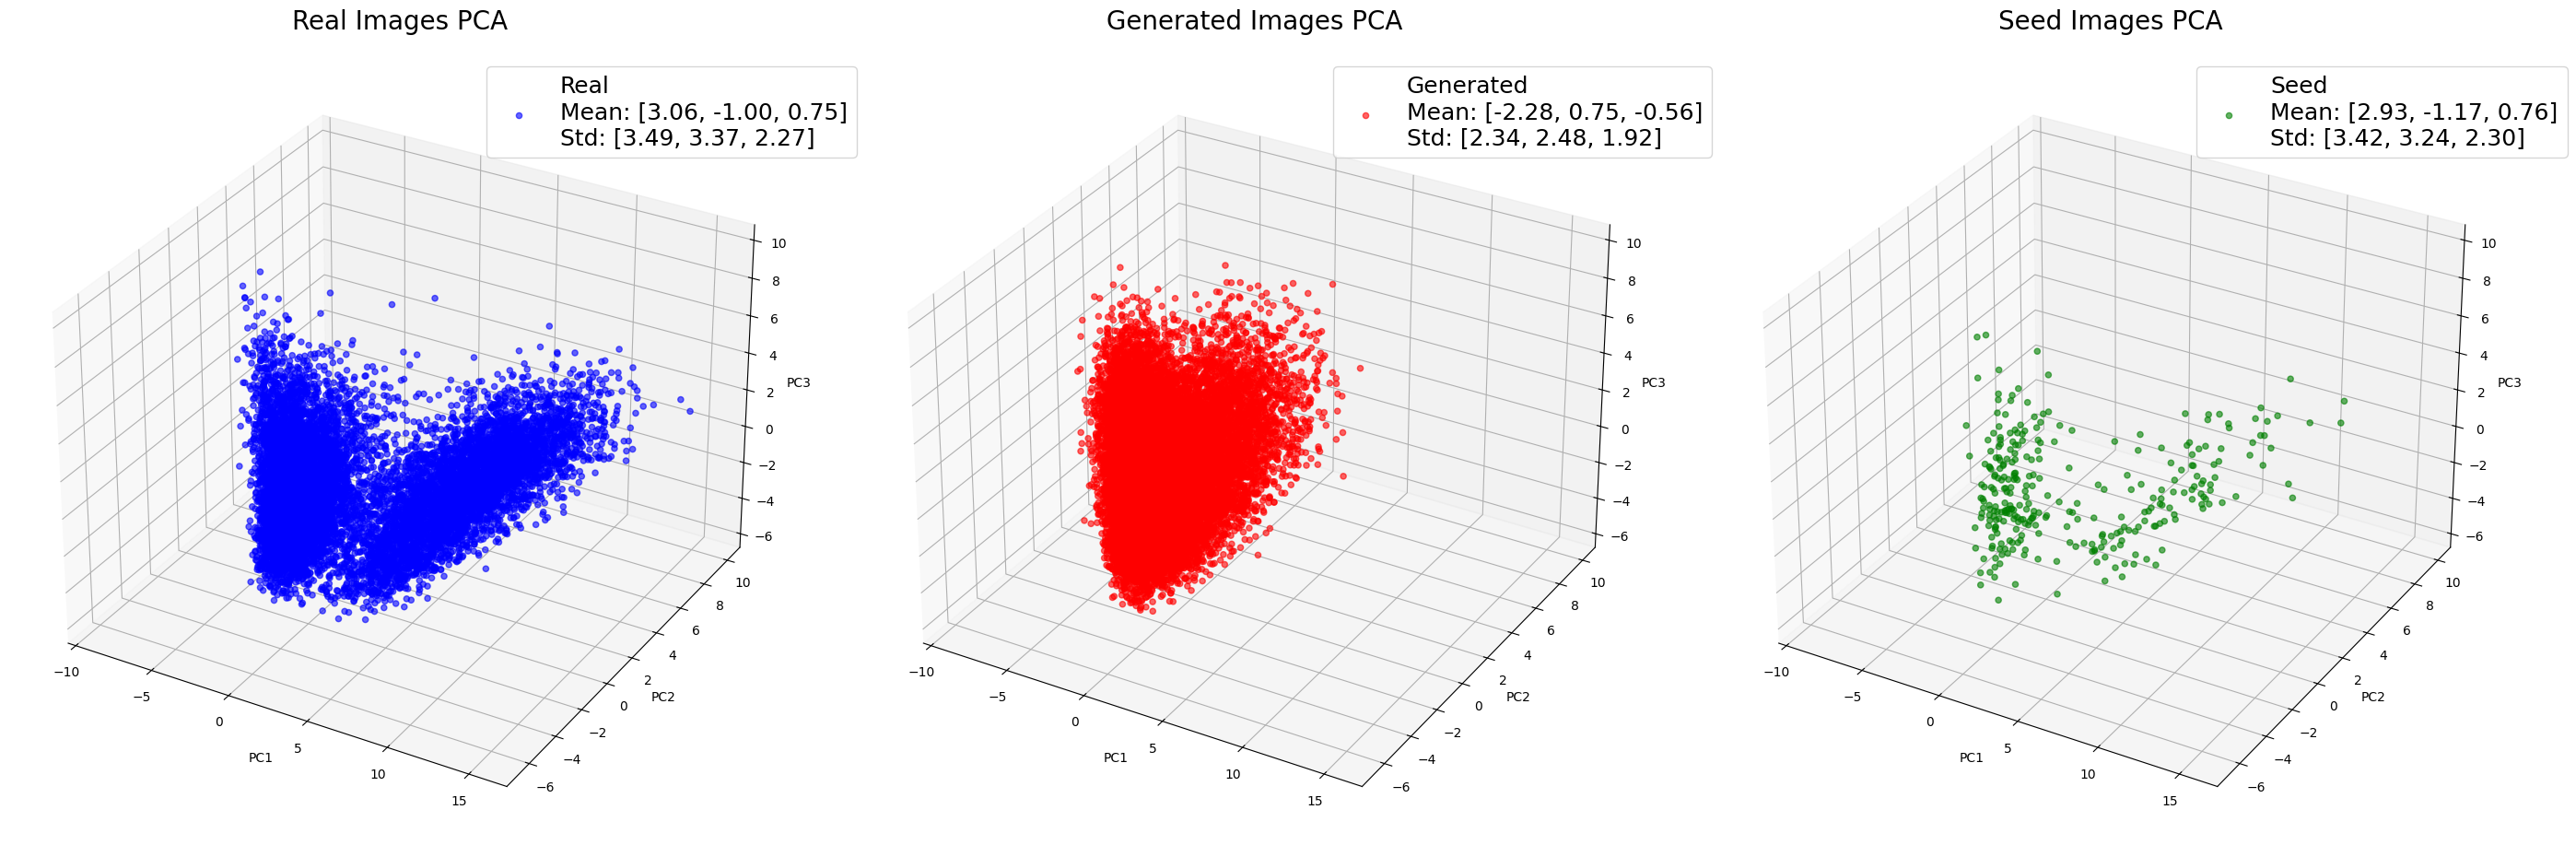


Подробные статистики:
Dataset | PC1 Mean | PC1 Std | PC2 Mean | PC2 Std | PC3 Mean | PC3 Std
------------------------------------------------------------------------------------------
Real | 3.06 | 3.49 | -1.00 | 3.37 | 0.75 | 2.27
Generated | -2.28 | 2.34 | 0.75 | 2.48 | -0.56 | 1.92
Seed | 2.93 | 3.42 | -1.17 | 3.24 | 0.76 | 2.30


In [93]:
pca = PCA(n_components=3)
combined_emb = np.vstack([real_emb, gen_emb, seed_emb])
pca.fit(combined_emb)

# Преобразуем все наборы
real_pca = pca.transform(real_emb)
gen_pca = pca.transform(gen_emb)
seed_pca = pca.transform(seed_emb)

# 7. Создание фигуры с 3D субплотами
fig = plt.figure(figsize=(28, 9))

# Общие пределы для всех графиков
all_pca = np.vstack([real_pca, gen_pca, seed_pca])
x_lim = (all_pca[:,0].min()-1, all_pca[:,0].max()+1)
y_lim = (all_pca[:,1].min()-1, all_pca[:,1].max()+1)
z_lim = (all_pca[:,2].min()-1, all_pca[:,2].max()+1)

# Функция для форматирования статистик
def get_stats_text(data, label):
    mean = data.mean(axis=0).round(2)
    std = data.std(axis=0).round(2)
    return (f"{label}\n"
            f"Mean: [{mean[0]:.2f}, {mean[1]:.2f}, {mean[2]:.2f}]\n"
            f"Std: [{std[0]:.2f}, {std[1]:.2f}, {std[2]:.2f}]")

# График для реальных данных (Real)
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(real_pca[:,0], real_pca[:,1], real_pca[:,2],
                 c='blue', alpha=0.6, label=get_stats_text(real_pca, "Real"))
ax1.set_title('Real Images PCA', pad=20, fontsize=20)
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)
ax1.set_zlim(z_lim)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend(handles=[sc1], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

# График для сгенерированных данных (Generated)
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(gen_pca[:,0], gen_pca[:,1], gen_pca[:,2],
                 c='red', alpha=0.6, label=get_stats_text(gen_pca, "Generated"))
ax2.set_title('Generated Images PCA', pad=20, fontsize=20)
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_zlim(z_lim)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend(handles=[sc2], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

# График для seed данных (Seed)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(seed_pca[:,0], seed_pca[:,1], seed_pca[:,2],
                 c='green', alpha=0.6, label=get_stats_text(seed_pca, "Seed"))
ax3.set_title('Seed Images PCA', pad=20, fontsize=20)
ax3.set_xlim(x_lim)
ax3.set_ylim(y_lim)
ax3.set_zlim(z_lim)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.legend(handles=[sc3], loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)

plt.tight_layout()
plt.show()

# 8. Детальный вывод статистик в консоль
print("\nПодробные статистики:")
print(f"{'Dataset'} | {'PC1 Mean'} | {'PC1 Std'} | {'PC2 Mean'} | {'PC2 Std'} | {'PC3 Mean'} | {'PC3 Std'}")
print("-" * 90)
for name, data in [('Real', real_pca), ('Generated', gen_pca), ('Seed', seed_pca)]:
    mean = data.mean(axis=0).round(2)
    std = data.std(axis=0).round(2)
    print(f"{name} | {mean[0]:.2f} | {std[0]:.2f} | {mean[1]:.2f} | {std[1]:.2f} | {mean[2]:.2f} | {std[2]:.2f}")

In [97]:
real_dataset = CustomImageDataset(['/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train'], transform=transform)
gen_dataset = CustomImageDataset(['/home/alexblokh/diffusion/data/generated_dataset/yolo_format/images/train'], transform=transform)


real_sample1 = real_dataset[np.argmax(real_pca[:,0])]  # Самый "правый" реальный
real_sample2 = real_dataset[np.argmin(real_pca[:,0])]     # Самый "левый" сгенерированный
# real_sample
# Визуально сравните
# plt.figure(figsize=(10,5))
# plt.subplot(121)
# plt.imshow(real_sample[0])
# plt.title("Real")
# plt.subplot(122)
# plt.imshow(gen_sample[0])
# plt.title("Generated")

/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train/2fe4d50f-3073ee5d.jpg
/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train/2e748b73-fec0f034.jpg


In [98]:
import cv2

cv2.imwrite('img1.jpg', cv2.imread('/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train/2fe4d50f-3073ee5d.jpg'))

cv2.imwrite('img2.jpg', cv2.imread('/mnt/nas3/homes/alex.blokh/ADAS/yolov8_car_detection/datasets/bdd10k/images/train/2e748b73-fec0f034.jpg'))

True